# Counts.txt

In [ ]:
# the data in counts.txt are ordered according to the measurement basis, in lexicographical order from XXXX to ZZZZ
# result '0' in the X basis means state |+>, in the Y basis |+i> and in the Z basis |0>

# Imports

In [1]:
from braket.circuits import Circuit
import numpy as np
import matplotlib.pyplot as plt
# AWS imports: Import Braket SDK modules
from braket.circuits import Circuit, Gate, Instruction, circuit, Observable
from braket.devices import LocalSimulator
from braket.aws import AwsDevice, AwsQuantumTask
import json
from scipy.linalg import sqrtm

In [3]:
# Please enter the S3 bucket you created during onboarding in the code below
my_bucket = "amazon-braket-1232454" # the name of the bucket
my_prefix = "test" # the name of the folder in the bucket

s3_folder = (my_bucket, my_prefix)

In [18]:
# the IonQ device
device = AwsDevice("arn:aws:braket:::device/qpu/ionq/ionQdevice")
supported_gates = device.properties.action['braket.ir.jaqcd.program'].supportedOperations
# print the supported gate set
print('Gate set supported by the IonQ device:\n', supported_gates)

Gate set supported by the IonQ device:
 ['x', 'y', 'z', 'rx', 'ry', 'rz', 'h', 'cnot', 's', 'si', 't', 'ti', 'v', 'vi', 'xx', 'yy', 'zz', 'swap', 'i']


# Creating the Cabello circuits

In [19]:
def create_tomo_circuit(basis):
    '''
    create the quantum circuit of the cabello state and measure in the chosen basis
    the basis is a 4-element vector containing 0s, 1s and 2s 
    from [0, 0, 0, 0] meaning XXXX to [2, 2, 2, 2] meaning ZZZZ
    '''
    # the cabello circuit creating the state 2|1100>+2|0011>-|1010>-|0101>-|1001>-|0110>
    istvan_circ = Circuit()
    istvan_circ.h(0)
    istvan_circ.h(1)
    istvan_circ.h(2)
    istvan_circ.rz(0, -0.73304)
    istvan_circ.rz(2, 2.67908)
    istvan_circ.cnot(2, 0)
    istvan_circ.ry(0, -2.67908)
    istvan_circ.h(2)
    istvan_circ.cnot(1, 0)
    istvan_circ.cnot(2, 3)
    istvan_circ.rz(2, 1.5708)
    istvan_circ.cnot(1, 3)
    istvan_circ.cnot(0, 2)
    # measurement. result '0' in the X basis means state |+>, in the Y basis |+i> and in the Z basis |0>
    for i in range(4):
        if basis[i] == 0:
            istvan_circ.h(i)
        elif basis[i] == 1:
            istvan_circ.si(i)
            istvan_circ.h(i)
    return istvan_circ

In [235]:
# the bases we need to measure the state in, 81=3^4 in total
# the bases go from XXXX to ZZZZ in lexicographical order, just like the results in counts.txt
bases = []
for i in range(3):
    for j in range(3):
        for k in range(3):
            for l in range(3):
                bases.append([i, j, k, l])

In [174]:
# extra bases, the bases containing the identity operator. we don't need to measure these
# basis states here are of the form [i, j, k, l] with i, j, k, l going from 0 to 3, 
# 0 = X, 1 = Y, 2 = Z and 3 = I
# and at least one of i, j, k, or l is 3
extra_bases = []
extra_bases.append([3, 3, 3, 3])
for i in range(3):
    extra_bases.append([i, 3, 3, 3])
    extra_bases.append([3, i, 3, 3])
    extra_bases.append([3, 3, i, 3])
    extra_bases.append([3, 3, 3, i])
    for j in range(3):
        extra_bases.append([3, 3, i, j])
        extra_bases.append([3, i, 3, j])
        extra_bases.append([3, i, j, 3])
        extra_bases.append([i, 3, 3, j])
        extra_bases.append([i, 3, j, 3])
        extra_bases.append([i, j, 3, 3])
        for k in range(3):
                extra_bases.append([i, j, k, 3])
                extra_bases.append([i, j, 3, k])
                extra_bases.append([i, 3, j, k])
                extra_bases.append([3, i, j, k])

# Running the Cabello circuits (costs money) and storing the results

In [ ]:
# this cell costs money to run
# runs and measures all 81 tomography circuits on the IonQ device with 8000 shots
# writes the results into a file
counts = []
for basis in bases:
    circ = create_tomo_circuit(basis)
    res = device.run(circ, s3_folder, shots=8000).result()
    counts.append(res.measurement_counts)
    f = open("counts.txt", "a")
    f.write(str(res.measurement_counts)+'\n')
    f.close()

In [34]:
# reads the results from the file and stores them in a list of dictionaries
counts = []
with open('counts.txt', 'r') as f:
    for line in f:
        l = line[8:-2].replace("'", '"')
        counts.append(json.loads(l))

In [53]:
# definition of basis measurement gates and pauli basis gates, needed for density matrix reconstruction
I = np.array([[1, 0], [0, 1]])
H = (1/np.sqrt(2))*np.array([[1, 1], [1, -1]])
HSi = (1/np.sqrt(2))*np.array([[1, -1j], [1, 1j]])
X = np.array([[0, 1], [1, 0]])
Y = np.array([[0, -1j], [1j, 0]])
Z = np.array([[1, 0], [0, -1]])

# Calculating and plotting the classical fidelities of the measurement results

In [10]:
def classical_fidelity(basis, counts, shots=8000):
    '''calculates the classical fidelity of the measured result (stored in the dictionary 'counts')
    with respect to the ideal cabello state in the chosen basis'''
    gates = [H, HSi, I]
    state = (1/np.sqrt(3))*np.array([0, 0, 0, 1, 0, -0.5, -0.5, 0, 0, -0.5, -0.5, 0, 1, 0, 0, 0])
    gate = np.kron(np.kron(np.kron(gates[basis[0]], gates[basis[1]]), gates[basis[2]]), gates[basis[3]])
    final_state = gate.dot(state)
    perf_probs = {f'{k:04b}': abs(final_state[k])**2 for k in range(16)}
    meas_probs = {bitstring: count / shots for (bitstring, count) in counts.items()}
    fidelity = 0
    for bitstring in perf_probs:
        fidelity += np.sqrt(perf_probs[bitstring]*meas_probs.get(bitstring, 0))
    return fidelity**2

In [35]:
# this cell can be used to calculate all the classical fidelities
fids = []
for i in range(81):
    fids.append(classical_fidelity(bases[i], counts[i], shots=8000))

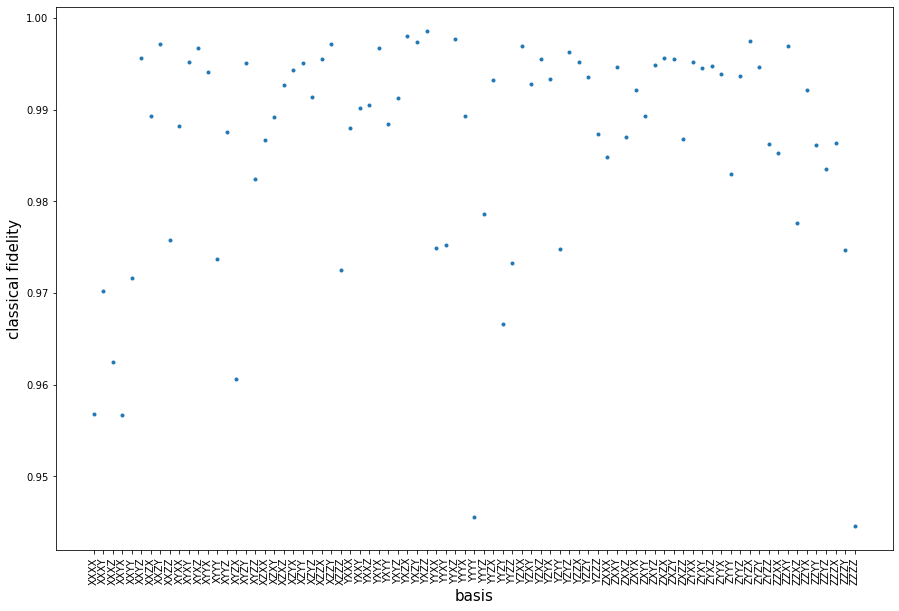

In [37]:
# plot the previously calculated classical fidelities
def basis_string(base):
    string = ''
    case = {0: 'X', 1: 'Y', 2: 'Z'}
    for i in range(len(base)):
        string += case[base[i]]
    return string
plt.figure(figsize=(15, 10))
plt.plot(fids, '.')
plt.ylabel('classical fidelity', fontsize=15)
xlabels = [f'{basis_string(b)}' for b in bases]
plt.xlabel('basis', fontsize=15)
plt.xticks(range(81), xlabels, rotation='vertical')
plt.show()

# Reconstructing the density matrix from tomography measurement results

In [274]:
# definitions: basis gates for tomography measurement, pauli basis gates, 
# and the Cabello state in the computational basis
tomo_gates = [H, HSi, I, I]
pauli_gates = [X, Y, Z, I]
state = (1/np.sqrt(3))*np.array([0, 0, 0, 1, 0, -0.5, -0.5, 0, 0, -0.5, -0.5, 0, 1, 0, 0, 0])

In [268]:
def density_matrix():
    '''
    Reconstruting the ideal density matrix from ideal (no shot noise) measurement results. 
    This function is not needed and was only used for debugging purposes.
    '''
    rho = np.zeros((16, 16), dtype='complex128')
    for (i, j, k, l) in bases:
        state = (1/np.sqrt(3))*np.array([0, 0, 0, 1, 0, -0.5, -0.5, 0, 0, -0.5, -0.5, 0, 1, 0, 0, 0])
        gate = np.kron(np.kron(np.kron(tomo_gates[i], tomo_gates[j]),
                               tomo_gates[k]), tomo_gates[l])
        final_state = gate.dot(state)
        perf_probs = {f'{k:04b}': abs(final_state[k])**2 for k in range(16)}
        pauli_matrix = np.kron(np.kron(np.kron(pauli_gates[i], pauli_gates[j]),
                                       pauli_gates[k]), pauli_gates[l])
        trace_rho = sum((-1)**(state.count('1') % 2)*perf_probs[state] for state in perf_probs)
        rho += trace_rho * pauli_matrix
    for basis in extra_bases:
        state = (1/np.sqrt(3))*np.array([0, 0, 0, 1, 0, -0.5, -0.5, 0, 0, -0.5, -0.5, 0, 1, 0, 0, 0])
        gate = np.kron(np.kron(np.kron(tomo_gates[basis[0]], tomo_gates[basis[1]]),
                           tomo_gates[basis[2]]), tomo_gates[basis[3]])
        final_state = gate.dot(state)
        perf_probs = {f'{k:04b}': abs(final_state[k])**2 for k in range(16)}
        pauli_matrix = np.kron(np.kron(np.kron(pauli_gates[basis[0]], pauli_gates[basis[1]]),
                                       pauli_gates[basis[2]]), pauli_gates[basis[3]])
        trace_rho = 0
        for curr_state in perf_probs:
            new_state = curr_state
            for i in range(len(basis)):
                if basis[i] == 3:
                    new_state = new_state[:i] + '0' + new_state[i+1:]
            trace_rho += (-1)**(new_state.count('1') % 2)*perf_probs[curr_state]
        rho += trace_rho * pauli_matrix
    return (1/16)*rho

In [308]:
def density_matrix(all_counts, shots=8000):
    '''
    Reconstructing the density matrix from the measurement results.
    The equation used (\sigma are the four Pauli matrices): 
    \rho = (1/16)*sum_{ijkl=0}^{3} {\sigma_i \sigma_j \sigma_k \sigma_l \Tr{\sigma_i \sigma_j \sigma_k \sigma_l \rho}},
    where \Tr{\sigma_i \sigma_j \sigma_k \sigma_l \rho} is estimated from the measurement results:
    \Tr{\sigma_i \sigma_j \sigma_k \sigma_l \rho} = (estimated as)
    = prob(measuring a bitstring with an even number of 1s in the ijkl basis) -
    - prob(measuring a bitstring with an odd number of 1s in the ijkl basis)
    with the special rule that if the basis on a qubit is \sigma_0(=identity) (where we don't have actual measurements),
    we consider it measuring 0 on that qubit by default.
    Output: the reconstructed density matrix.
    '''
    rho = np.zeros((16, 16), dtype='complex128')
    for (basis, counts) in zip(bases, all_counts):
        meas_probs = {bitstring: count / shots for (bitstring, count) in counts.items()}
        pauli_matrix = np.kron(np.kron(np.kron(pauli_gates[basis[0]], pauli_gates[basis[1]]),
                                       pauli_gates[basis[2]]), pauli_gates[basis[3]])
        trace_rho = sum((-1)**(state.count('1') % 2)*meas_probs[state] for state in meas_probs)
        rho += trace_rho * pauli_matrix
    for basis in extra_bases:
        og_basis = [b if b!=3 else 2 for b in basis]
        no = og_basis[0]*27+og_basis[1]*9+og_basis[2]*3+og_basis[3]
        meas_probs = {bitstring: count / shots for (bitstring, count) in all_counts[no].items()}
        pauli_matrix = np.kron(np.kron(np.kron(pauli_gates[basis[0]], pauli_gates[basis[1]]),
                                       pauli_gates[basis[2]]), pauli_gates[basis[3]])
        trace_rho = 0
        for curr_state in meas_probs:
            new_state = curr_state
            for i in range(len(basis)):
                if basis[i] == 3:
                    new_state = new_state[:i] + '0' + new_state[i+1:]
            trace_rho += (-1)**(new_state.count('1') % 2)*meas_probs[curr_state]
        rho += trace_rho * pauli_matrix
    return (1/16)*rho

# Calculating the quantum fidelity

In [318]:
def quantum_fidelity(rho1, rho2):
    '''Function to calculate the quantum fidelity between two density matrices rho1 and rho2'''
    return (np.trace(sqrtm(np.matmul(np.matmul(sqrtm(rho1), rho2), sqrtm(rho1)))))**2

In [309]:
# the density matrix reconstructed from measurements
rho_meas = density_matrix(all_counts)

In [162]:
# calculate the density matrix of the ideal Cabello state
state = (1/np.sqrt(3))*np.array([0, 0, 0, 1, 0, -0.5, -0.5, 0, 0, -0.5, -0.5, 0, 1, 0, 0, 0])
rho_ideal = np.outer(state, state)

In [ ]:
# the quantum fidelity of the reconstructed density matrix
quantum_fidelity(rho_meas, rho_ideal)